In [1]:
!pip install more-itertools networkx==2.8.8 seaborn==0.12.2 Pillow

In [2]:
import math
import heapq as hpq
import time
import glob
import multiprocessing as mlp
import sys
from typing import List, Tuple, Union

import numpy as np
import pandas as pd
import scipy.stats as ss
from itertools import combinations
from more_itertools import powerset
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
import PIL as pil
import IPython.display as ipd

## Algorithms implementation

#### Checing Euler's cycle existence

In [3]:
def semi_connected(G: nx.MultiGraph):
    comp = { v: None for v in G.nodes }
    nontrivial_cnt = 0
    for label, component in enumerate(nx.connected_components(G)):
        for v in component:
            comp[v] = label
        
        nontrivial_cnt += int(len(component) > 1)
        
    return nontrivial_cnt <= 1


#### Building Euler's cycle of minimal cost

In [4]:
def eulerize(G: nx.MultiGraph, dist_G: nx.MultiGraph, return_graph = False):
    H = nx.MultiGraph(G)
    
    if (H.order() == 0):
        raise nx.NetworkXPointlessConcept("Cannot Eulerize null graph")
    
    if (not semi_connected(H)):
        raise nx.NetworkXError("G is not semi-connected")
        
    odd_degree_nodes = [n for n, d in H.degree() if d % 2 == 1]
    if (len(odd_degree_nodes) == 0):
        return (0, H) if (return_graph) else 0
    
    comp = { v: None for v in H.nodes }
    for label, component in enumerate(nx.connected_components(H)):
        for v in component:
            comp[v] = label

    odd_deg_pairs_paths = []
    for m, n in combinations(odd_degree_nodes, 2):
        if (comp[m] != comp[n]):
            continue
        
        if (return_graph):
            odd_deg_pairs_paths.append((m, {n: (
                nx.shortest_path(dist_G, source = m, target = n, weight = "weight"),
                nx.shortest_path_length(dist_G, source = m, target = n, weight = "weight")
            )}))
        else:
            odd_deg_pairs_paths.append((m, {n:
                nx.shortest_path_length(dist_G, source = m, target = n, weight = "weight")
            }))

    Gp = nx.Graph()
    for n, Ps in odd_deg_pairs_paths:
        if (return_graph):
            for m, (P, W) in Ps.items():
                Gp.add_edge(m, n, weight = W, path = P)
                
        else:
            for m, W in Ps.items():
                Gp.add_edge(m, n, weight = W)

    additional_weight = 0
    for m, n in nx.min_weight_matching(Gp):
        additional_weight += Gp[m][n]["weight"]
        
        if (return_graph):
            path = Gp[m][n]["path"]
            H.add_edges_from(nx.utils.pairwise(path))

    return (additional_weight, H) if (return_graph) else additional_weight


#### Solving Chinese Postman Problem

In [5]:
def ChinesePostmanProblem(G: nx.MultiGraph, dist_G: nx.MultiGraph = None, return_cycle = False):
    if (dist_G is None):
        dist_G = G
    
    if (return_cycle):
        w, H = eulerize(G, dist_G, return_graph = True)
        w += G.size(weight = "weight")
        
        deg = dict(H.degree)
        for v, d in deg.items():
            if (d == 0):
                H.remove_node(v)
        
        cycle, _ = zip(*list(nx.eulerian_circuit(H)))
        return w, list(cycle)
    
    else:
        return eulerize(G, dist_G) + G.size(weight = "weight")


#### Baseline solution for Rural Postman Problem

In [6]:
def RuralPostmanProblemBaseline(G: nx.MultiGraph):
    edges = G.edges(data = True)
    main_edges = list(filter(lambda ed: not "travel" in ed[2] or not ed[2]["travel"], edges))
    travel_edges = list(filter(lambda ed: "travel" in ed[2] and ed[2]["travel"], edges))
    
    base_H = nx.MultiGraph(main_edges)
    
    best = None
    for st in powerset(travel_edges):
        H = nx.MultiGraph(base_H)
        H.add_edges_from(st)
        
        if (not semi_connected(H)):
            continue
        
        w = ChinesePostmanProblem(H)
        
        if (best is None or best[0] > w):
            best = (w, st)
    
    base_H.add_edges_from(best[1])
    w, cycle = ChinesePostmanProblem(base_H, return_cycle = True)
    
    return w, cycle


#### Solution for Rural Postman Problem with different heuristics

In [7]:
def sort_vertices(u, v):
    if (u < v):
        return (u, v)
    else:
        return (v, u)

In [8]:
class RPPSubproblem:

    def __init__(self, G, dist_G, task):
        self.G = nx.MultiGraph(G)
        self.dist_G = dist_G
        self.cost = math.inf
        self.task = task
        
        if (semi_connected(G)):
            self.cost = ChinesePostmanProblem(G, dist_G, return_cycle = False)


    def __lt__(self, p):
        return self.cost < p.cost


#### Different heuristics implementation

In [9]:
def get_max_otp(nodes, otp):
    ans = None
    for u, v in combinations(nodes, 2):
        if (otp[(u, v)] is None):
            continue

        if (ans is None or ans[0] < otp[(u, v)]):
            ans = (otp[(u, v)], u, v)
            
    return ans


def get_min_otp(nodes, otp):
    ans = None
    for u, v in combinations(nodes, 2):
        if (otp[(u, v)] is None):
            continue

        if (ans is None or ans[0] > otp[(u, v)]):
            ans = (otp[(u, v)], u, v)
            
    return ans


def get_random_otp(nodes, otp):
    res = []
    for u, v in combinations(nodes, 2):
        if (otp[(u, v)] is None):
            continue

        res.append((otp[(u, v)], u, v))
    
    if (len(res) == 0):
        return None
    
    return res[np.random.randint(len(res))]


In [10]:
def RuralPostmanProblem(G: nx.MultiGraph, get_otp = get_max_otp, return_stats = False):
    edges = G.edges(data = True)
    main_edges = list(filter(lambda ed: not "travel" in ed[2] or not ed[2]["travel"], edges))
    travel_edges = list(filter(lambda ed: "travel" in ed[2] and ed[2]["travel"], edges))
    
    if (len(travel_edges) == 0):
        w, cycle = ChinesePostmanProblem(G, return_cycle = True)
        return (w, 0, 0) if (return_stats) else (w, cycle)
    
    nodes = list(G.nodes)
    
    travel_dist = dict()
    true_dist = dict()
    
    for u, v in combinations(nodes, 2):
        travel_dist[(u, v)] = math.inf
        true_dist[(u, v)] = math.inf
    
    travel_G = nx.MultiGraph(travel_edges)
    
    for u, dist in nx.all_pairs_dijkstra_path_length(travel_G):
        for v, w in dist.items():
            travel_dist[sort_vertices(u, v)] = w
    
    for u, dist in nx.all_pairs_dijkstra_path_length(G):
        for v, w in dist.items():
            true_dist[sort_vertices(u, v)] = w

    cover_G = nx.MultiGraph(main_edges)
    cover_G.add_nodes_from(travel_G.nodes)
    
    comp = { v: None for v in nodes }
    for label, component in enumerate(nx.connected_components(cover_G)):
        for v in component:
            comp[v] = label
            
    otp = { (v, v): None for v in nodes }
    for u, v in combinations(nodes, 2):
        otp[(u, v)] = None
        
        if (comp[u] != comp[v] and \
            travel_dist[(u, v)] != math.inf and \
            true_dist[(u, v)] != math.inf and \
            travel_dist[(u, v)] == true_dist[(u, v)]):
            
            otp[(u, v)] = true_dist[(u, v)]
        
        if (not (otp[(u, v)] is None)):
            cover_G.add_edge(u, v, key = (u, v), weight = 0)
    
    dist_G = nx.MultiGraph(cover_G)
    
    for u, v in combinations(nodes, 2):
        if (comp[u] != comp[v]):
            continue
        
        if (travel_dist[(u, v)] == math.inf):
            continue
        
        dist_G.add_edge(u, v, key = (u, v), weight = true_dist[(u, v)])
    
    del travel_dist, true_dist, travel_G
    
    otp_seq = []
    res = get_otp(nodes, otp)
    while (not (res is None)):
        w, u, v = res
        otp[(u, v)] = None
        otp_seq.append((w, u, v))
        
        res = get_otp(nodes, otp)
    
    # print(label + 1, "components with", len(otp_seq), "OTPs")
    
    pq = []
    hpq.heappush(pq, RPPSubproblem(cover_G, dist_G, 0))
    del cover_G
    
    iter_count = 0
    while (len(pq) > 0):
        iter_count += 1
        
        s = hpq.heappop(pq)
        cur_G = s.G
        cur_dist_G = s.dist_G
        task = s.task
        
        if (task >= len(otp_seq)):
            w, cycle = ChinesePostmanProblem(cur_G, cur_dist_G, return_cycle = True)
            return (w, iter_count, len(otp_seq)) if (return_stats) else (w, cycle)

        w, u, v = otp_seq[task]
        
        cur_G.remove_edge(u, v, key = (u, v))
        cur_dist_G.remove_edge(u, v, key = (u, v))
        hpq.heappush(pq, RPPSubproblem(cur_G, cur_dist_G, task + 1))
        
        cur_G.add_edge(u, v, key = (u, v), weight = w)
        cur_dist_G.add_edge(u, v, key = (u, v), weight = w)
        hpq.heappush(pq, RPPSubproblem(cur_G, cur_dist_G, task + 1))
        
    raise Exception("something has gone completely wrong...")


## Visualization and benchmarking framework

In [11]:
def make_gif(frame_folder, duration = 1000):
    frames = [pil.Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(
        f"{frame_folder}/all.gif",
        format = "GIF",
        append_images = frames[1 :],
        save_all = True,
        duration = duration,
        loop = 0)


#### Visualization of algorithm processing sample graph

In [12]:
def get_sample_graph():
    G = nx.Graph()

    G.add_edge("a", "b", weight = 6, travel = True)
    G.add_edge("a", "c", weight = 2, travel = True)
    G.add_edge("c", "d", weight = 1, travel = True)
    G.add_edge("c", "e", weight = 7)
    G.add_edge("c", "f", weight = 9)
    G.add_edge("a", "d", weight = 3)
    G.add_edge("c", "g", weight = 1, travel = True)
    G.add_edge("b", "g", weight = 10)
    G.add_edge("e", "f", weight = 3, travel = True)
    G.add_edge("g", "f", weight = 1, travel = True)
    G.add_edge("d", "e", weight = 1, travel = True)
    G.add_edge("a", "h", weight = 2, travel = True)
    G.add_edge("h", "i", weight = 2)
    G.add_edge("h", "j", weight = 3)
    
    return G


In [13]:
def visualize():
    matplotlib.rcParams['savefig.dpi'] = 300
    
    G = get_sample_graph()
    
    e_cover = [(u, v) for (u, v, d) in G.edges(data = True) if ("travel" not in d or not d["travel"])]
    e_travel = [(u, v) for (u, v, d) in G.edges(data = True) if ("travel" in d and d["travel"])]

    node_positions = {
        "a": (-2, 0),
        "b": (-8, 0),
        "c": (1, 0),
        "d": (1, -2),
        "e": (4, -1),
        "f": (5, 1),
        "g": (1, 2),
        "h": (-5, -1),
        "i": (-8, -1),
        "j": (-1, -2)
    }
    pos = nx.spring_layout(G, pos = node_positions, fixed = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

    nx.draw_networkx_nodes(G, pos, node_size = 700)

    nx.draw_networkx_edges(G, pos, edgelist = e_cover, width = 6)
    nx.draw_networkx_edges(
        G, pos, edgelist = e_travel, width = 6, alpha = 0.5, edge_color = "b", style = "dashed"
    )

    nx.draw_networkx_labels(G, pos, font_size = 20, font_family = "sans-serif")

    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    plt.title("Initial graph")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("graph_plots/sample/0.png")
    plt.close()
    
    e_travel_used = [('a', 'b'), ('g', 'f'), ('e', 'd'), ('a', 'h')]
    e_travel_unused = [('a', 'c'), ('c', 'g'), ('f', 'e'), ('c', 'd')]
    
    nx.draw_networkx_nodes(G, pos, node_size = 700)

    nx.draw_networkx_edges(G, pos, edgelist = e_cover, width = 6)
    nx.draw_networkx_edges(
        G, pos, edgelist = e_travel_used, width = 6, edge_color = "orange", style = "dashed"
    )
    nx.draw_networkx_edges(
        G, pos, edgelist = e_travel_unused, width = 6, alpha = 0.5, edge_color = "b", style = "dashed"
    )

    nx.draw_networkx_labels(G, pos, font_size = 20, font_family = "sans-serif")

    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    plt.title("Chosen optional edges")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("graph_plots/sample/00.png")
    plt.close()
    
    w, cycle = RuralPostmanProblem(G)
    cycle.append(cycle[0])
    
    e_visited = []
    last_v = None
    for i, v in enumerate(cycle):
        if (not (last_v is None)):
            e_visited.append((last_v, v))
        
        last_v = v
        
        nx.draw_networkx_nodes(G, pos, node_size = 700)
        nx.draw_networkx_nodes(G, pos, node_size = 700, nodelist = [v], node_color = "#ff0000")

        nx.draw_networkx_edges(G, pos, edgelist = e_cover, width = 6)
        nx.draw_networkx_edges(
            G, pos, edgelist = e_travel_used, width = 6, edge_color = "orange", style = "dashed"
        )
        nx.draw_networkx_edges(
            G, pos, edgelist = e_travel_unused, width = 6, alpha = 0.5, edge_color = "b", style = "dashed"
        )
        nx.draw_networkx_edges(G, pos, edgelist = e_visited, width = 6, edge_color = "r")

        nx.draw_networkx_labels(G, pos, font_size = 20, font_family = "sans-serif")

        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels)

        plt.title(f"Step #{i}")

        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.tight_layout()
        plt.savefig("graph_plots/sample/step-" + "{0:0>2}".format(i + 1) + ".png")
        plt.close()
        
    make_gif("graph_plots/sample/", duration = [2000, 2000, *([700] * len(cycle))])
    ipd.display(ipd.Image(filename = f"graph_plots/sample/all.gif", width = 900))


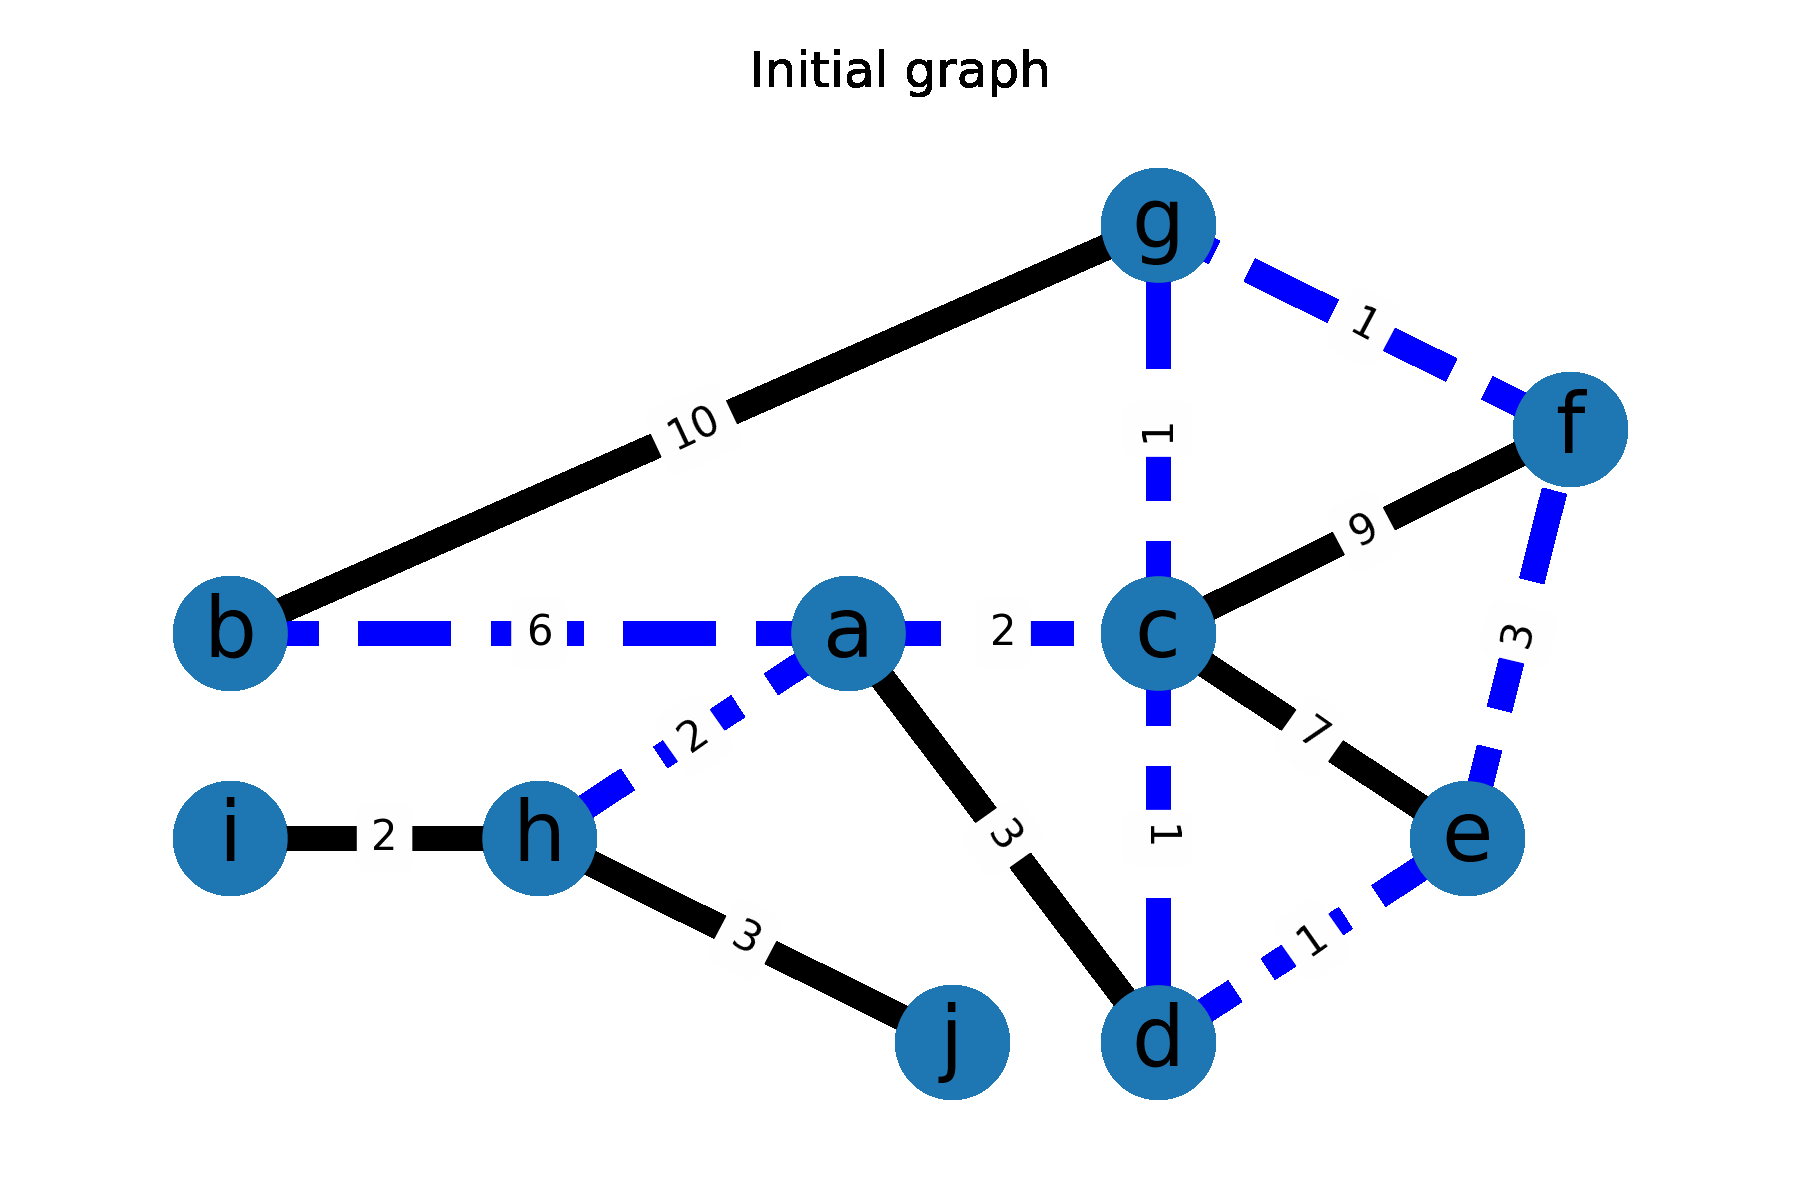

In [14]:
visualize()

#### Benchmarking framework

In [15]:
def load_graph(path, weighted = False, integer_labels = True):
    G = nx.Graph()
    
    with open(path, "r") as file:
        for line in file.readlines()[1 :]:
            tokens = line.strip().split()
            
            if (integer_labels):
                tokens[0 : 2] = list(map(int, tokens[0 : 2]))
            
            if (weighted):
                tokens[2] = float(tokens[2])
            
            if (not weighted):
                G.add_edge(tokens[0], tokens[1], weight = 1)
            else:
                G.add_edge(tokens[0], tokens[1], weight = tokens[2])
                
    return G


This function was invoked on remote machine to collect benchmark data.

In [16]:
def run_benchmarks():
    def get_result(G, get_otp, iters, otps, comps):
        _, iters.value, otps.value, comps.value = RuralPostmanProblem(G, get_otp = get_otp, return_stats = True)

    with open(f"graph_results/{sys.argv[1]}.txt", "a") as file:
        file.write("===\n")

    while True:
        iters = mlp.Value('i', 0)
        otps = mlp.Value('i', 0)
        comps = mlp.Value('i', 0)

        G = load_graph(f"graph_data/{sys.argv[1]}.txt", weighted = bool(int(sys.argv[2])))

        edges = list(G.edges)
        travel_edges_cnt = np.random.randint(1, min(int(sys.argv[3]), len(edges)) + 1)
        ind = np.random.choice(np.arange(len(edges)), size = travel_edges_cnt)

        for i in ind:
            u, v = edges[i]
            G.edges[u, v]["travel"] = True

        for (get_otp, otp_type) in zip([get_max_otp, get_min_otp, get_random_otp], ["max", "min", "rnd"]):
            print(f"{otp_type} {len(G.nodes)} {len(G.edges)} {travel_edges_cnt}")

            p = mlp.Process(target = get_result, args = (G, get_otp, iters, otps, comps))
            p.start()

            p.join(5 * 60)

            if (p.is_alive()):
                p.kill()
                p.join()
                print("timeout")
                continue

            if (comps.value > 1):
                with open(f"graph_results/{sys.argv[1]}.txt", "a") as file:
                    file.write(f"{otp_type} {len(G.nodes)} {len(G.edges)} {travel_edges_cnt} {otps.value} {comps.value} {iters.value}\n")

                print("ok")
            else:
                break


#### Drawing results

In [17]:
def show_plots(name, xlim, ylim):
    matplotlib.rcParams['savefig.dpi'] = "figure"
    
    data = pd.read_csv(f"graph_results/{name}.csv")
    
    sns.set_style("ticks")
    sns.set_context("talk")
    
    plot = sns.jointplot(
        data = data,
        x = "t", y = "otps",
        height = 10.5, ratio = 10,
        xlim = (0, max(data["t"].max(), data["otps"].max()) + 5),
        ylim = (0, max(data["t"].max(), data["otps"].max()) + 5)
    )
    plt.suptitle(name)
    plt.show()
    
    if (xlim[1] is None):
        xlim = (0, data["otps"].max() + 5)
    
    for ind, (otp_type, color) in enumerate(zip(["max", "rnd", "min"], ["tab:blue", "tab:green", "tab:orange"]), 1):
        plot = sns.jointplot(
            data = data.query(f"type == '{otp_type}'"),
            x = "otps", y = "iters", hue = "type",
            palette = [color],
            height = 20, ratio = 10,
            xlim = xlim, ylim = ylim
        )
        plt.suptitle(name)
        plot.savefig(f"graph_plots/{name}/{ind}.png")
        plt.close()
    
    make_gif(f"graph_plots/{name}/")
    ipd.display(ipd.Image(filename = f"graph_plots/{name}/all.gif", width = 900))
    
    plot = sns.jointplot(
        data = data,
        x = "otps", y = "iters", hue = "type",
        height = 10.5, ratio = 10,
        xlim = xlim, ylim = ylim
    )
    plt.suptitle(name)
    plt.savefig(f"graph_plots/{name}/composed.jpg")
    plt.show()
    
def show_info(name, xlim, ylim):
    show_plots(name, xlim, ylim)
    
    data = pd.read_csv(f"graph_results/{name}.csv")
    
    iters_max, iters_min, iters_rnd = [], [], []
    for i in range(1, data.shape[0] - 1):
        if (data.at[i - 1, "type"] == "max" \
            and data.at[i, "type"] == "min" \
            and data.at[i + 1, "type"] == "rnd" \
            and data.at[i - 1, "t"] == data.at[i, "t"] \
            and data.at[i, "t"] == data.at[i + 1, "t"] \
            and data.at[i - 1, "otps"] == data.at[i, "otps"] \
            and data.at[i, "otps"] == data.at[i + 1, "otps"]):

            iters_max.append(data.at[i - 1, "iters"])
            iters_min.append(data.at[i, "iters"])
            iters_rnd.append(data.at[i + 1, "iters"])
    
    iters_max, iters_min, iters_rnd = np.array(iters_max), np.array(iters_min), np.array(iters_rnd)
    
    data = pd.concat((
        pd.DataFrame({"type": ["max"] * len(iters_max), "iters": iters_max}),
        pd.DataFrame({"type": ["min"] * len(iters_min), "iters": iters_min}),
        pd.DataFrame({"type": ["rnd"] * len(iters_rnd), "iters": iters_rnd})
    ))
    sns.barplot(data = data, x = "type", y = "iters")
    plt.savefig(f"graph_plots/{name}/means.jpg")
    plt.show()
    
    def print_formatted(iters, otp_type):
        print(f"{otp_type}:", end = " ")
        
        res = "{:.3f}".format(iters.mean())
        res = "{0: >8}".format(res)
        print(res, end = " ± ")
        
        res = "{:.3f}".format(iters.std(ddof = 1))
        res = "{0: >8}".format(res)
        print(res, end = " | ")
        
        print("median value is", end = " ")
        print("{0: >6}".format(np.median(iters)))
    
    
    print_formatted(iters_max, "max")
    print_formatted(iters_min, "min")
    print_formatted(iters_rnd, "rnd")


#### Tests

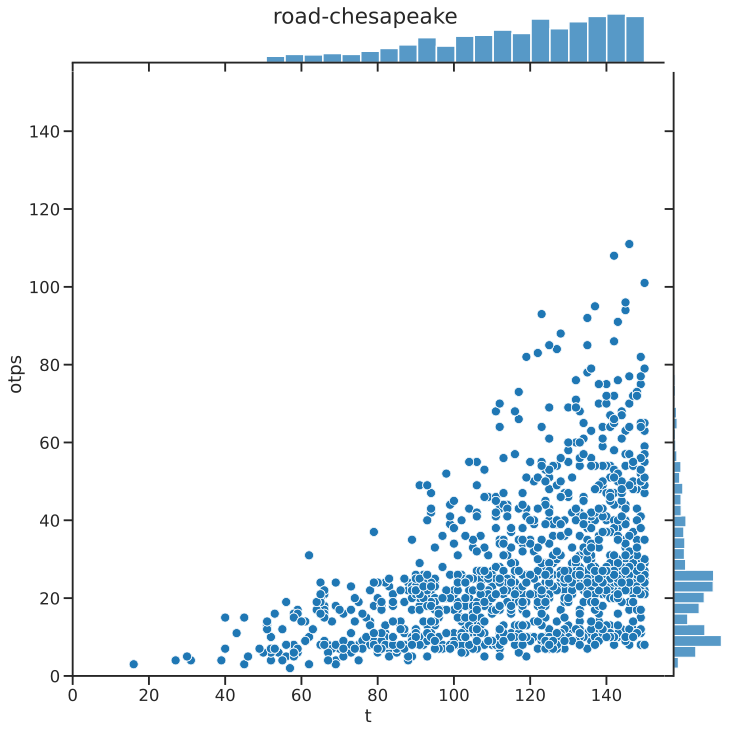

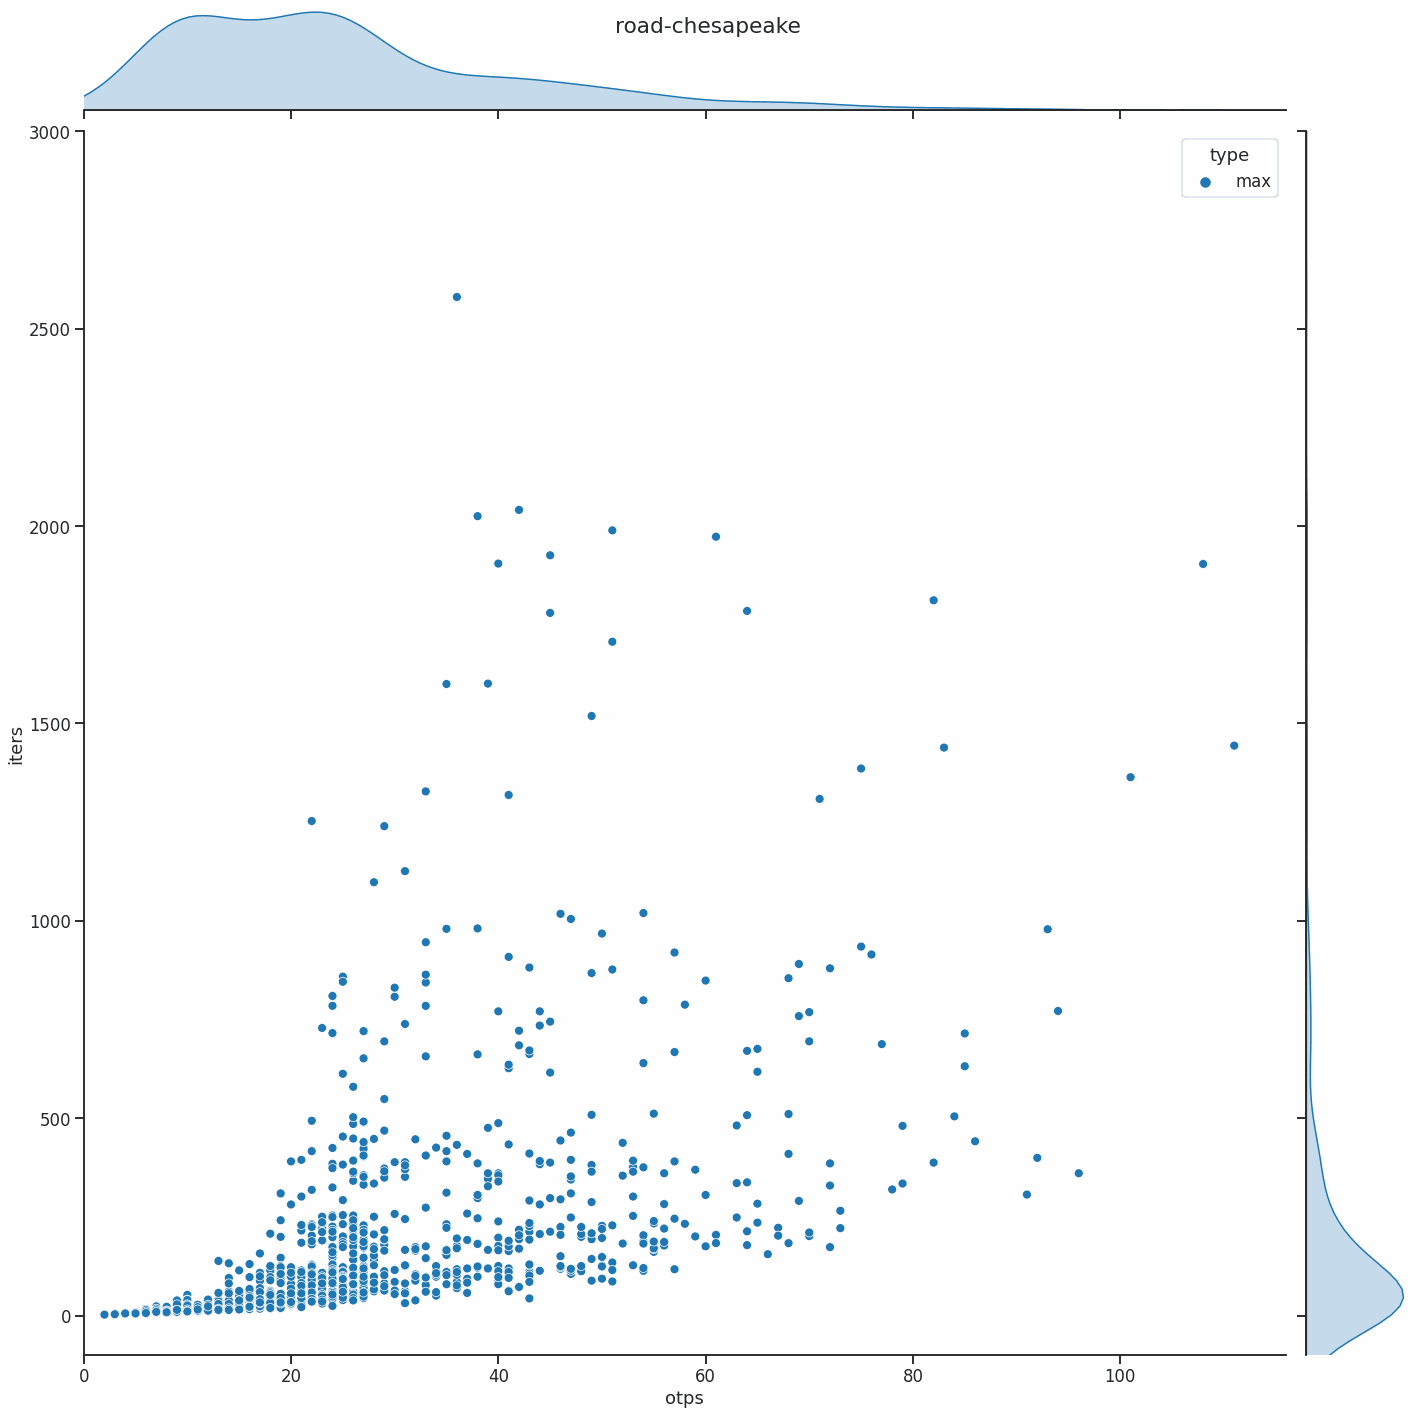

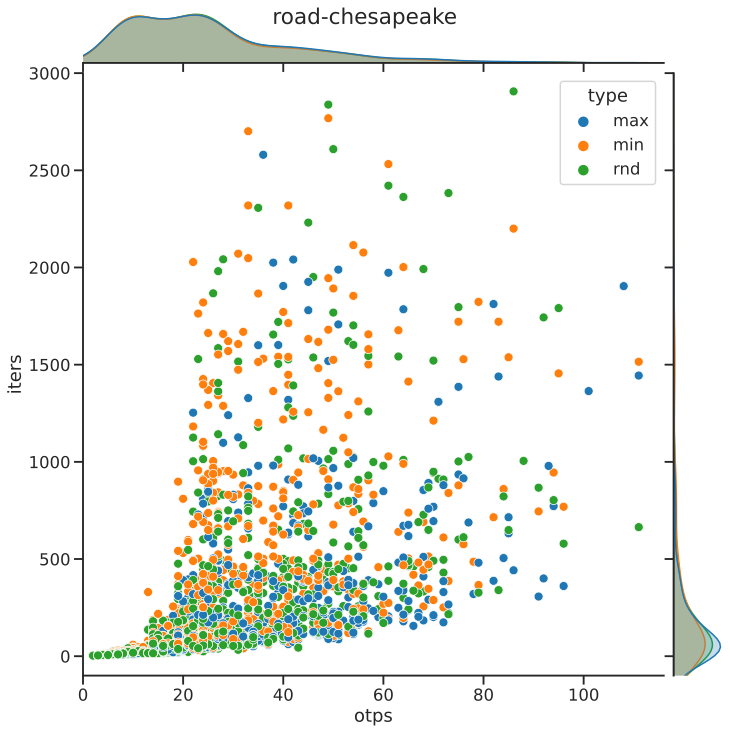

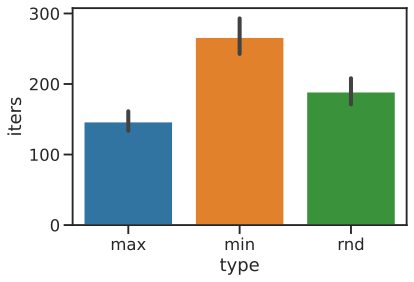

max:  146.628 ±  231.805 | median value is   62.0
min:  266.304 ±  415.352 | median value is   98.5
rnd:  189.036 ±  319.462 | median value is   81.0


In [18]:
show_info("road-chesapeake", xlim = (0, None), ylim = (-100, 3000))

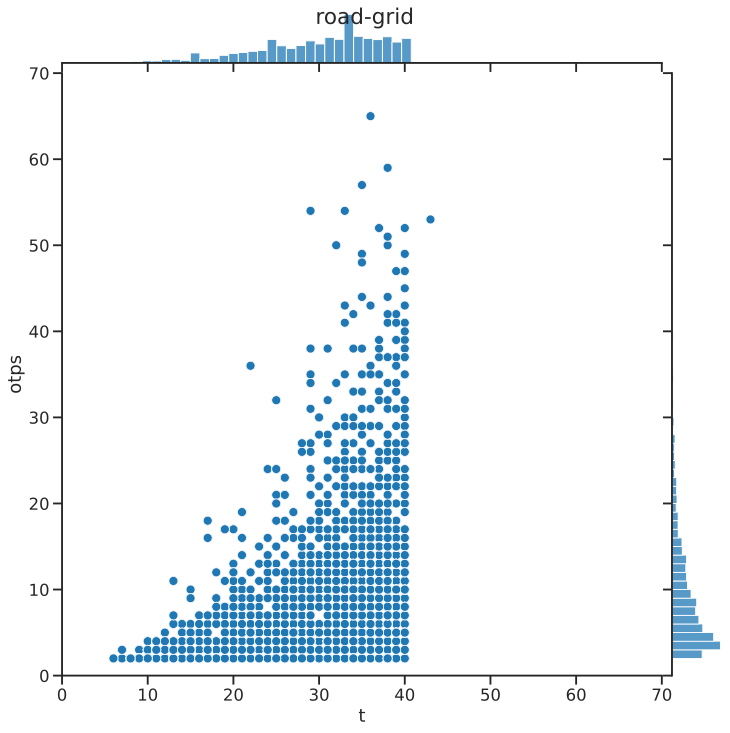

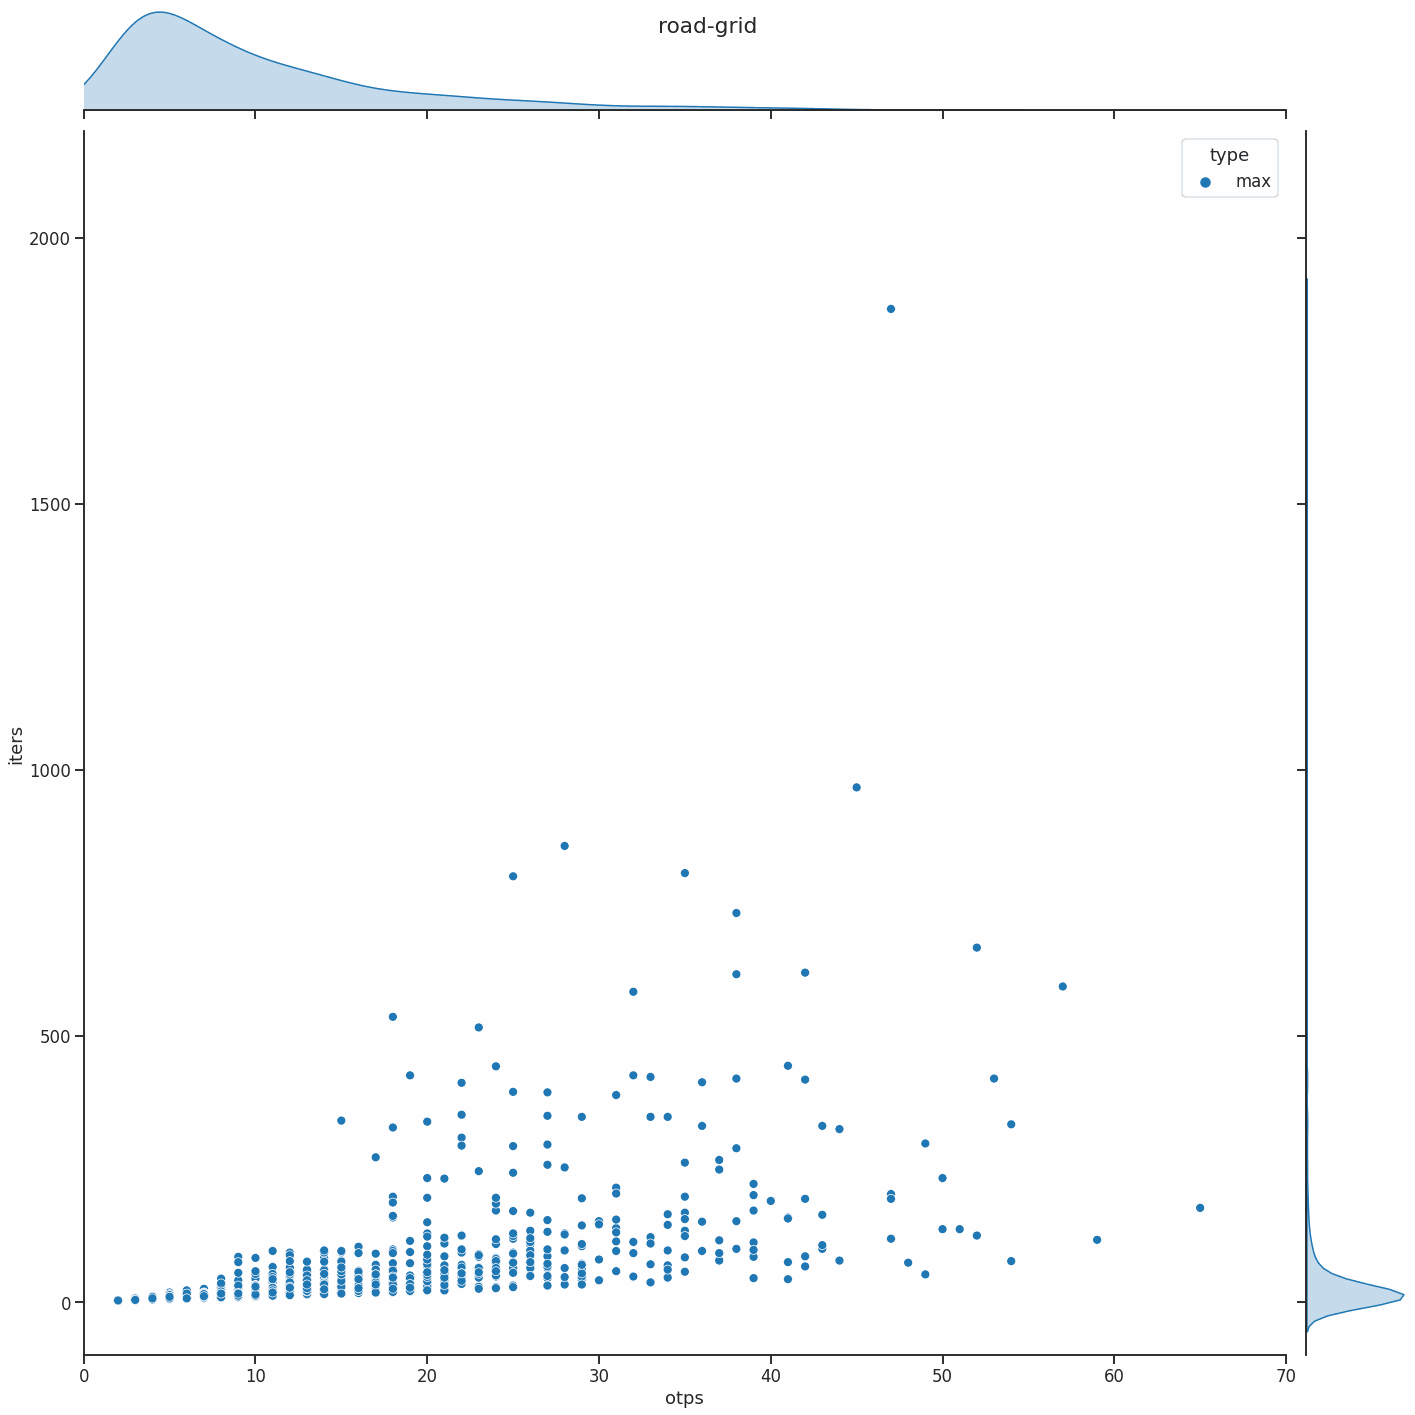

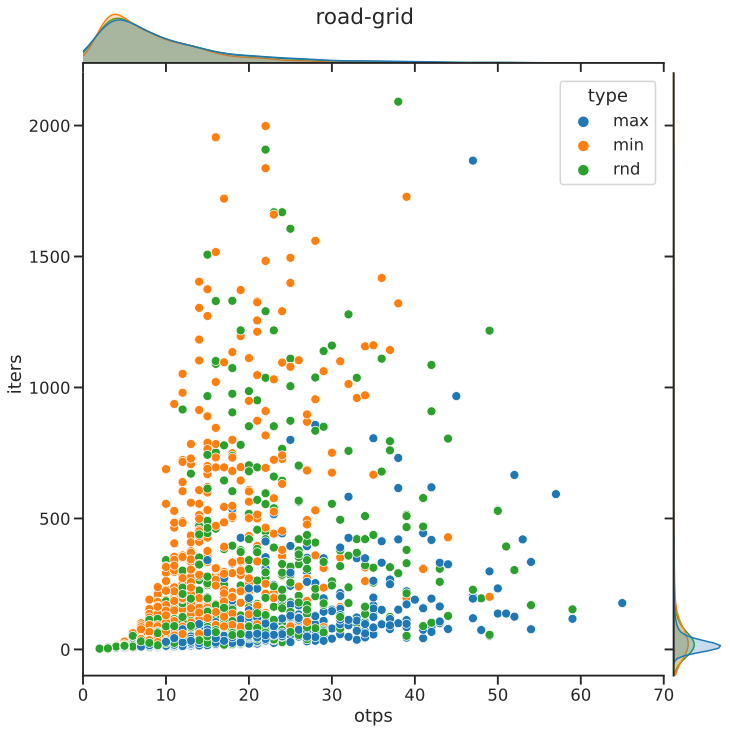

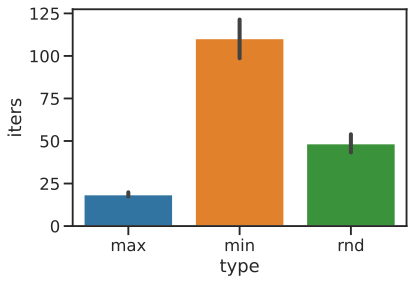

max:   18.517 ±   25.018 | median value is   10.0
min:  110.287 ±  248.648 | median value is   20.0
rnd:   48.508 ±  115.811 | median value is   14.0


In [19]:
show_info("road-grid", xlim = (0, None), ylim = (-100, 2200))

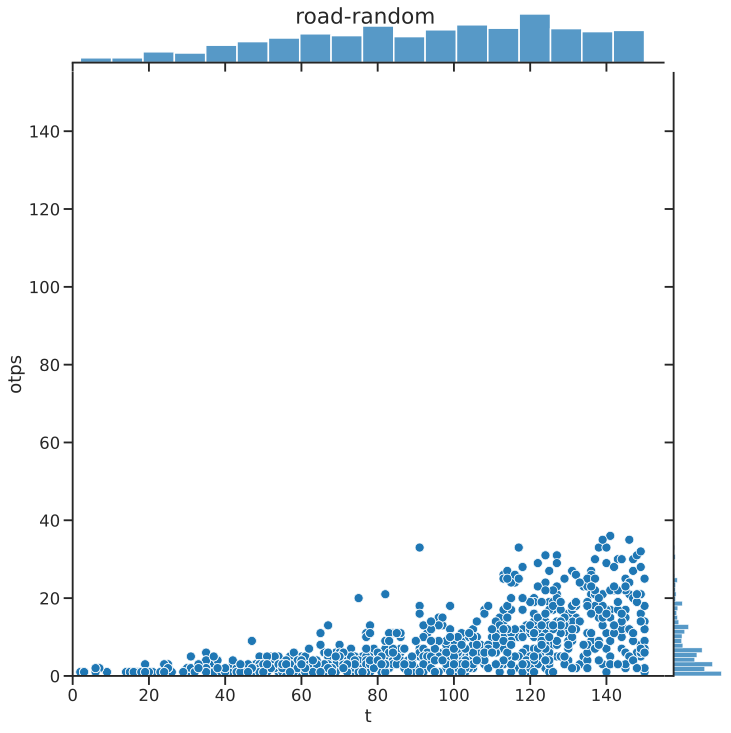

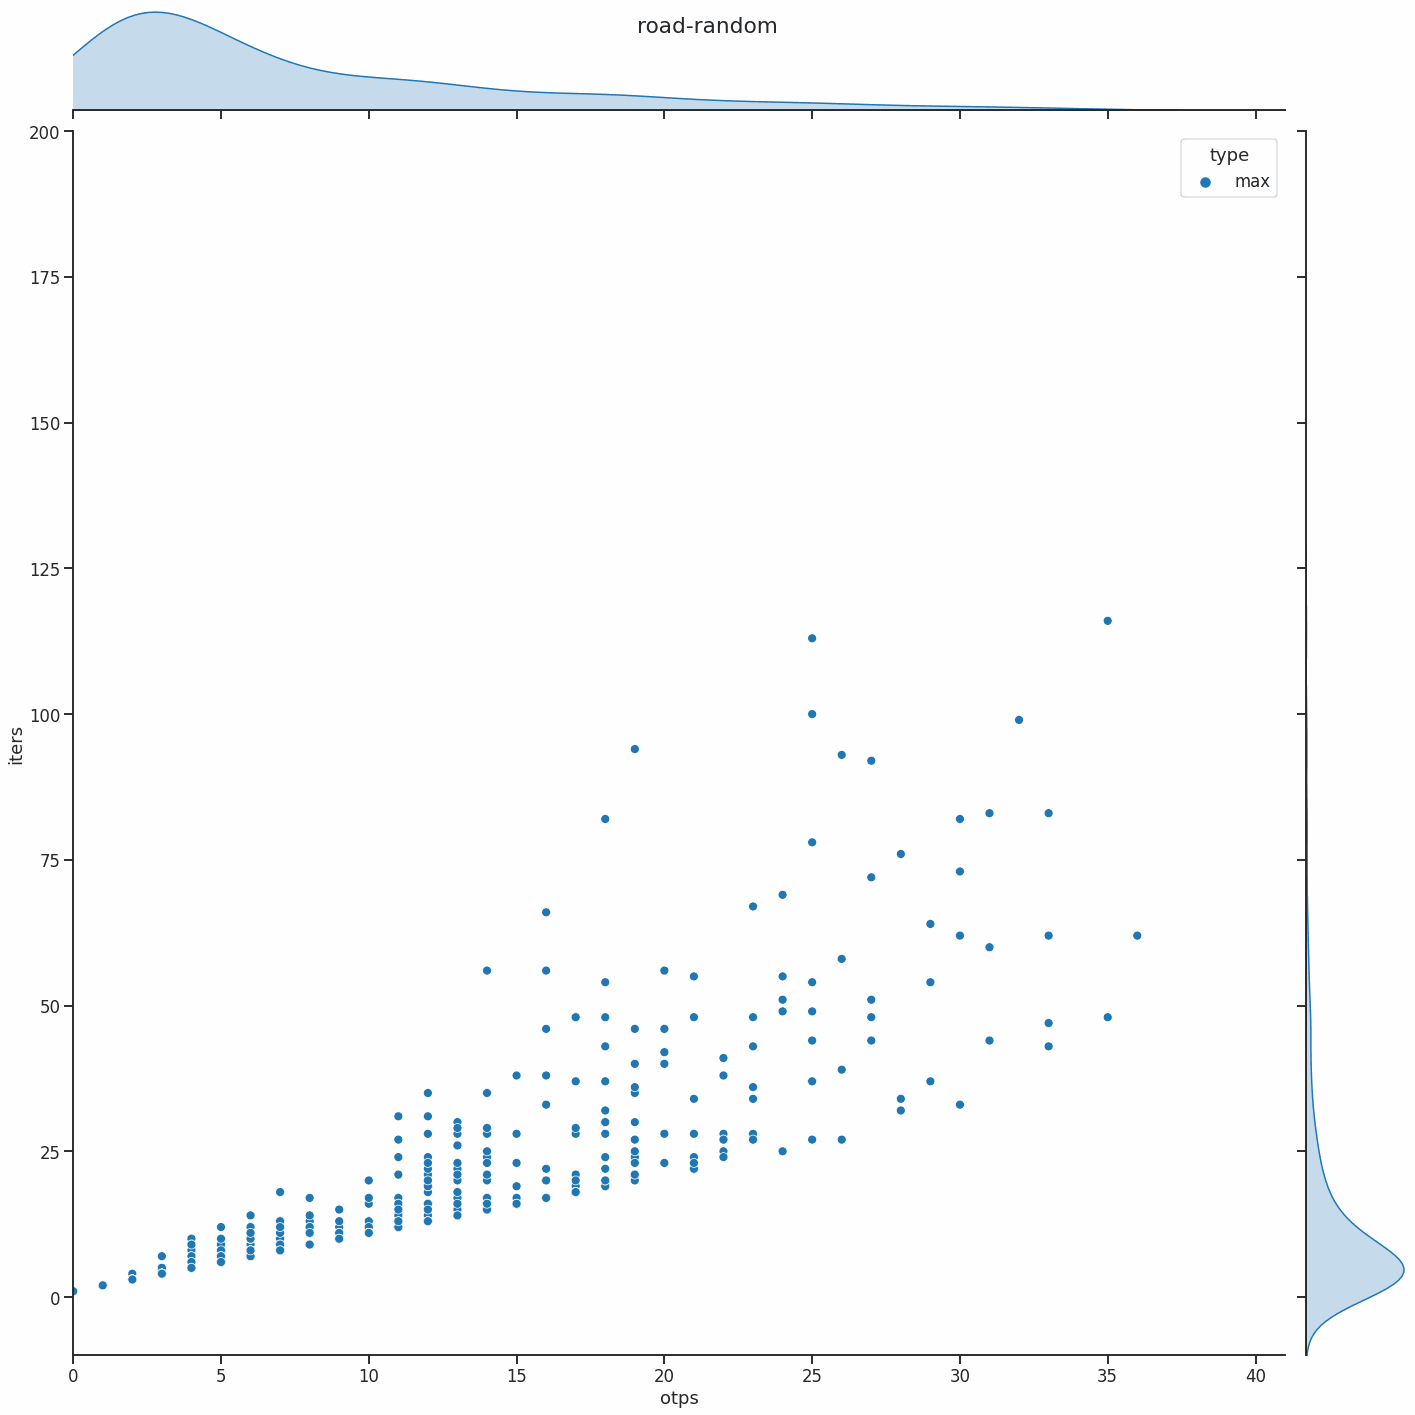

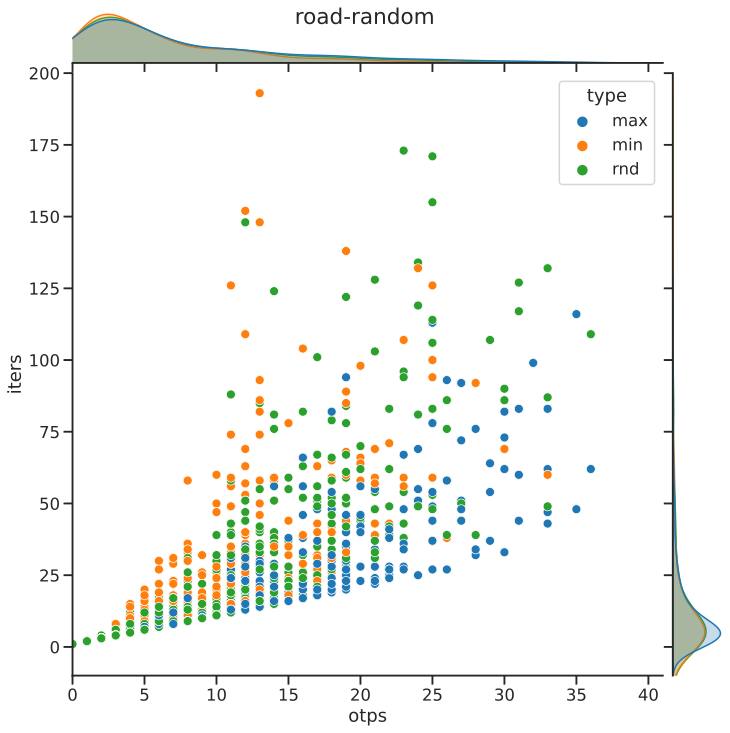

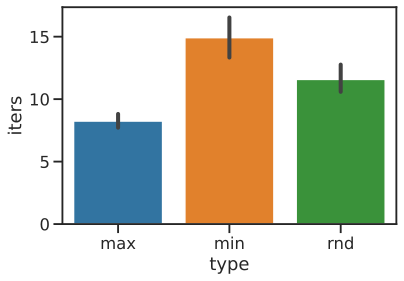

max:    8.248 ±    7.711 | median value is    5.0
min:   14.922 ±   23.079 | median value is    6.0
rnd:   11.583 ±   15.551 | median value is    6.0


In [20]:
show_info("road-random", xlim = (0, None), ylim = (-10, 200))

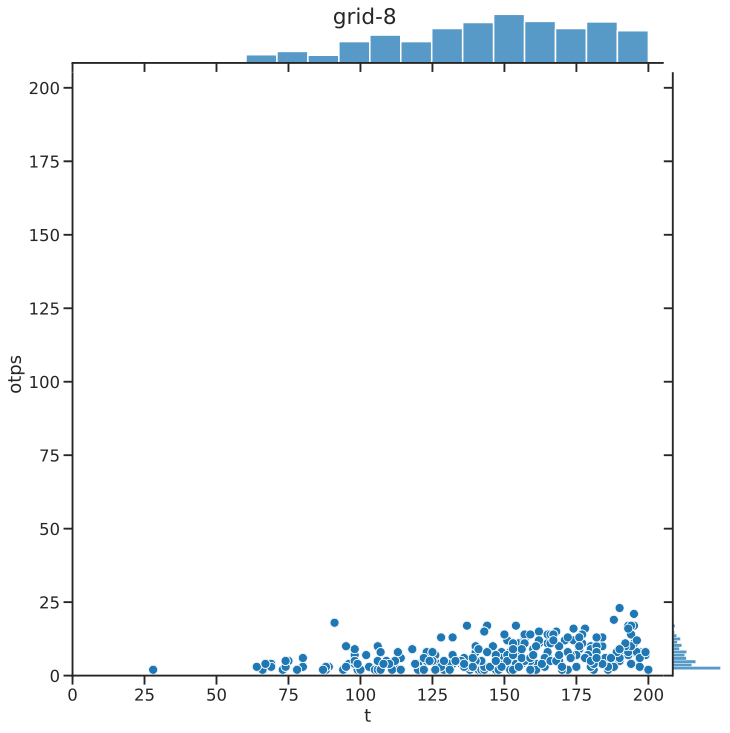

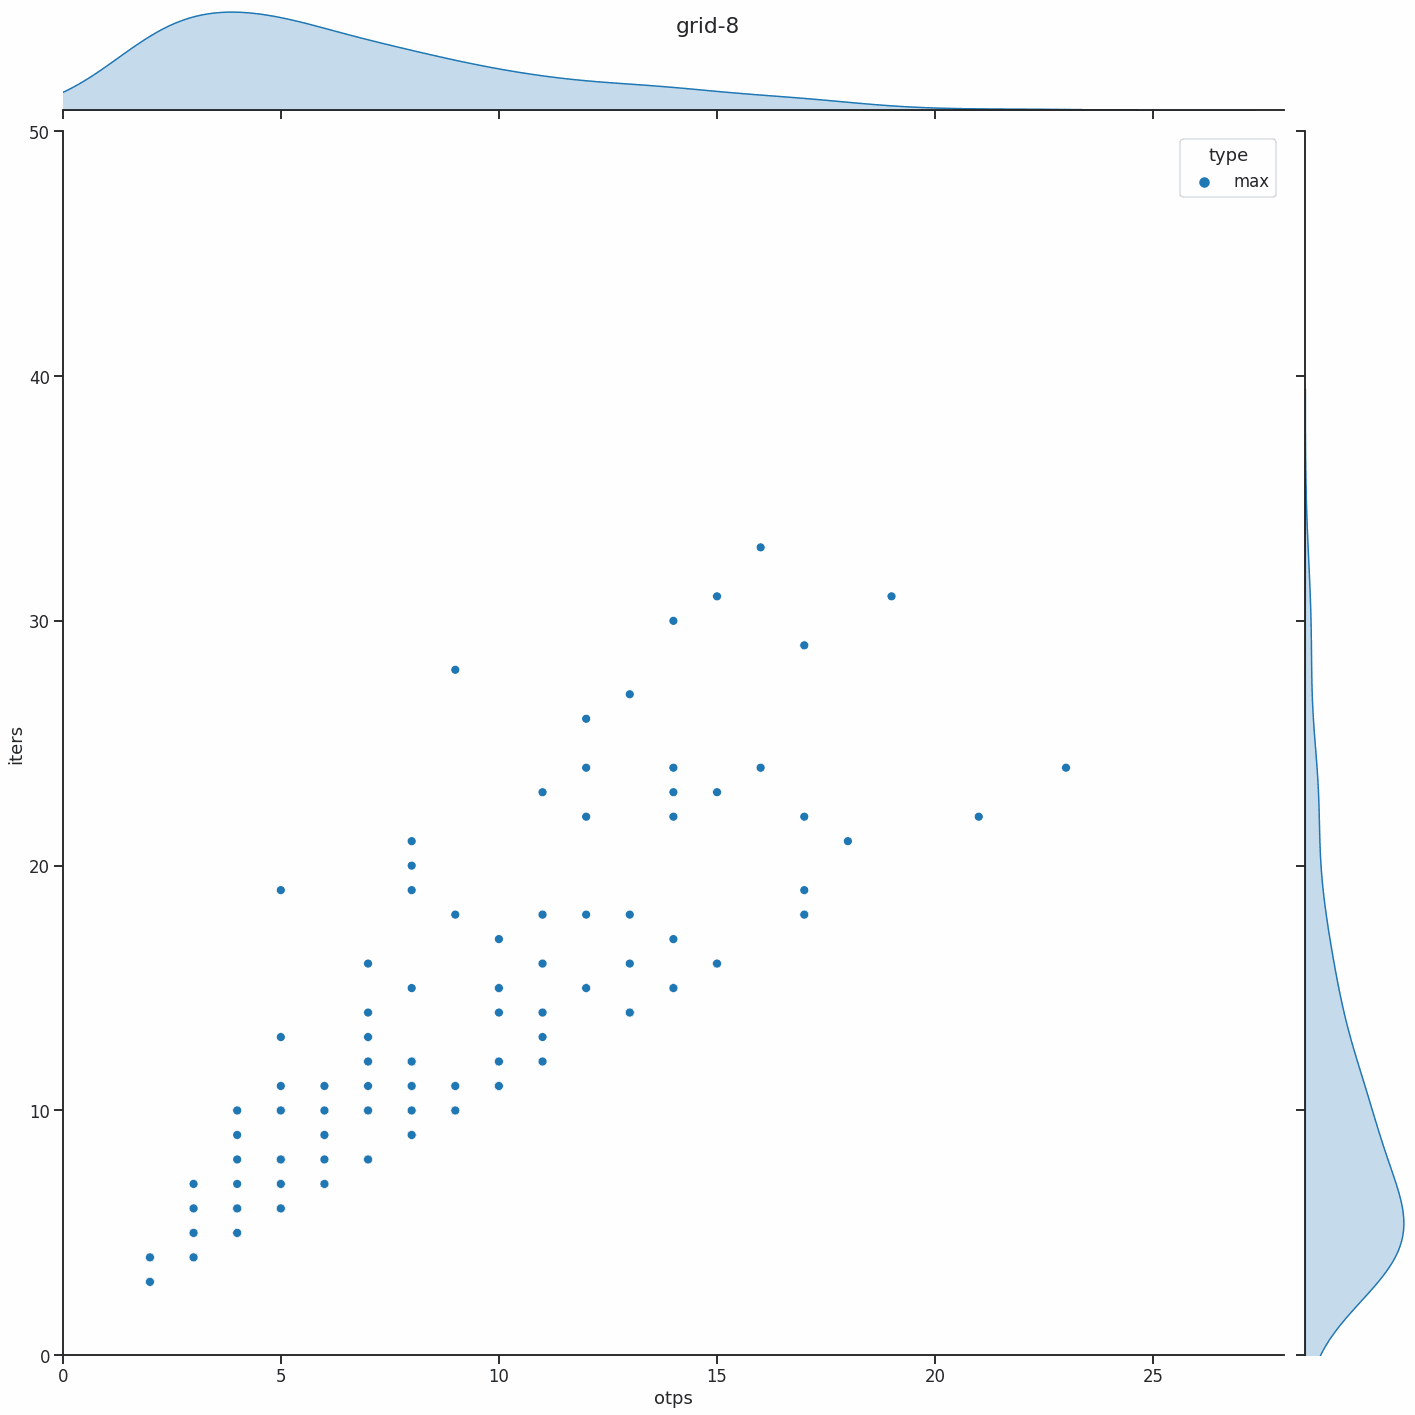

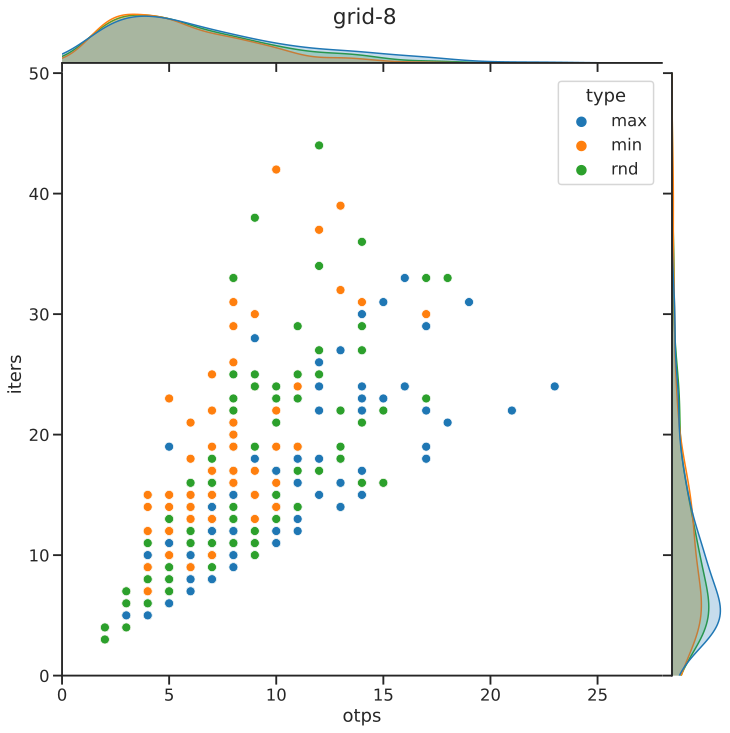

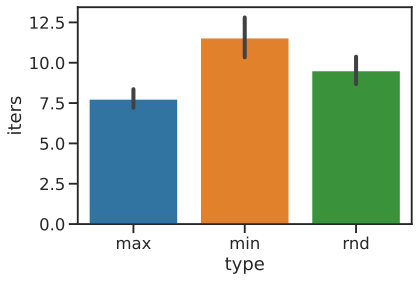

max:    7.760 ±    4.280 | median value is    7.0
min:   11.554 ±    8.754 | median value is    9.5
rnd:    9.520 ±    6.284 | median value is    8.0


In [21]:
show_info("grid-8", xlim = (0, None), ylim = (0, 50))

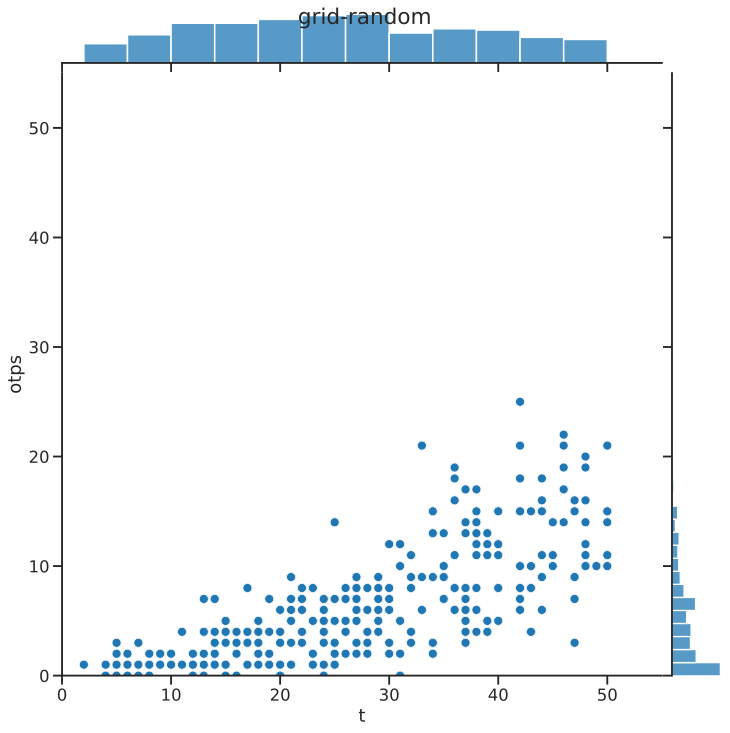

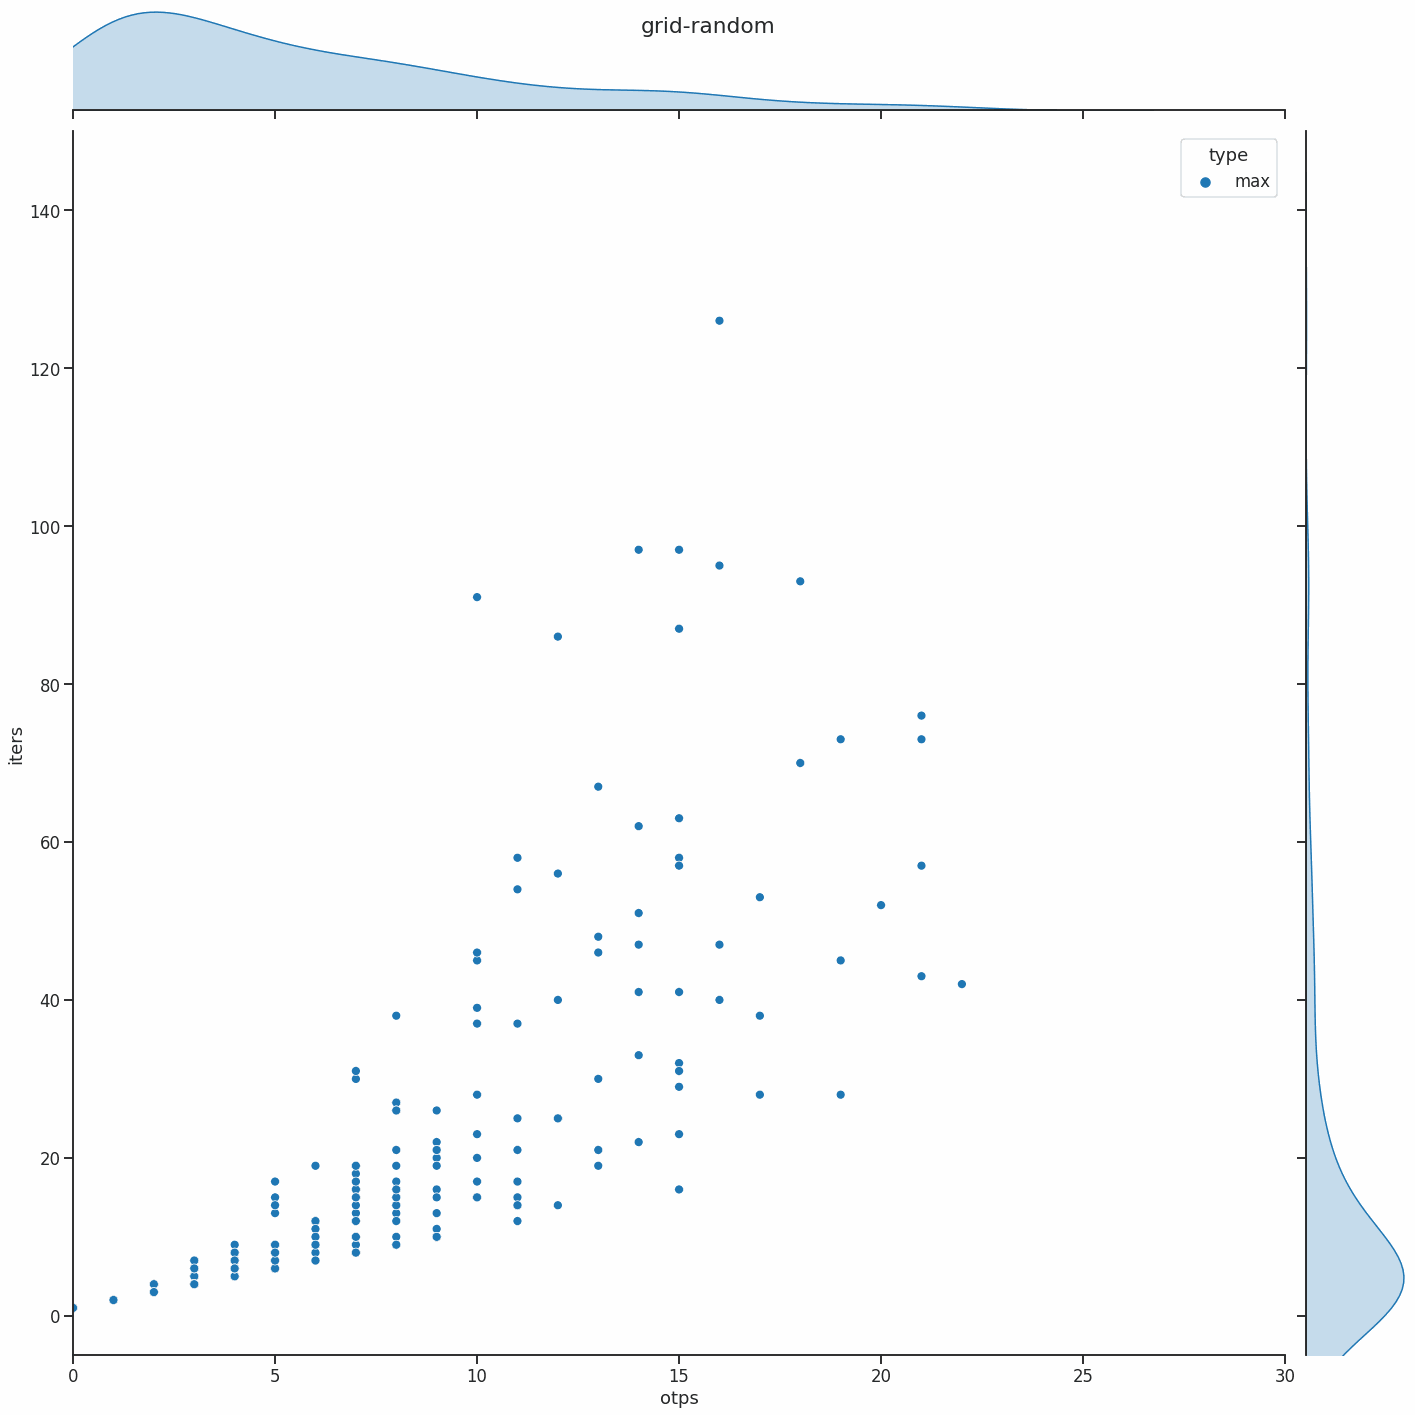

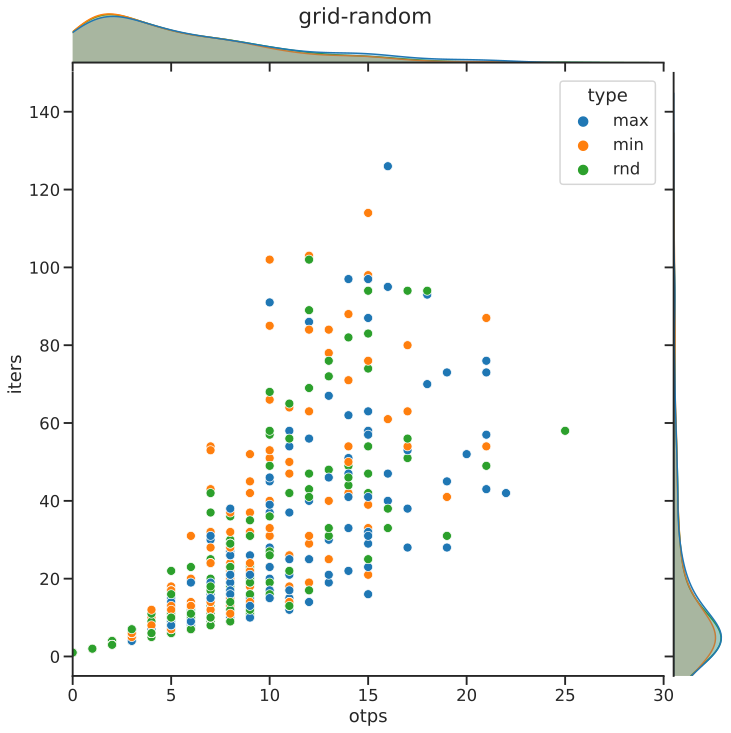

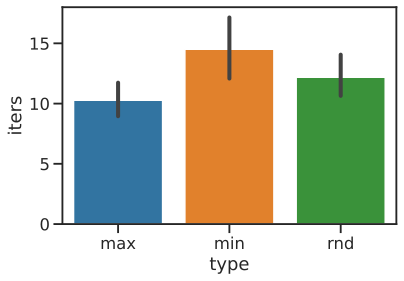

max:   10.277 ±   12.730 | median value is    6.0
min:   14.508 ±   20.436 | median value is    6.0
rnd:   12.189 ±   16.085 | median value is    6.0


In [22]:
show_info("grid-random", xlim = (0, None), ylim = (-5, 150))

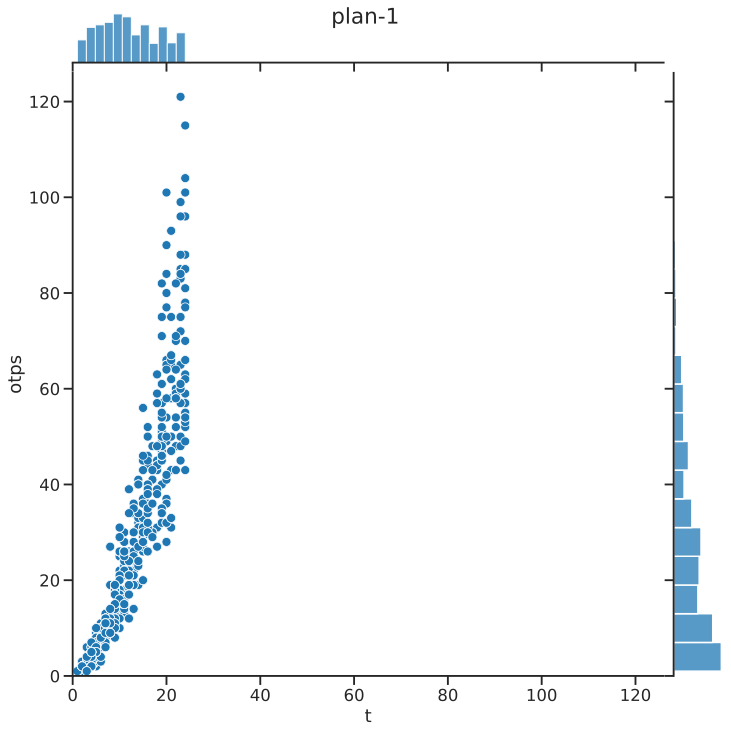

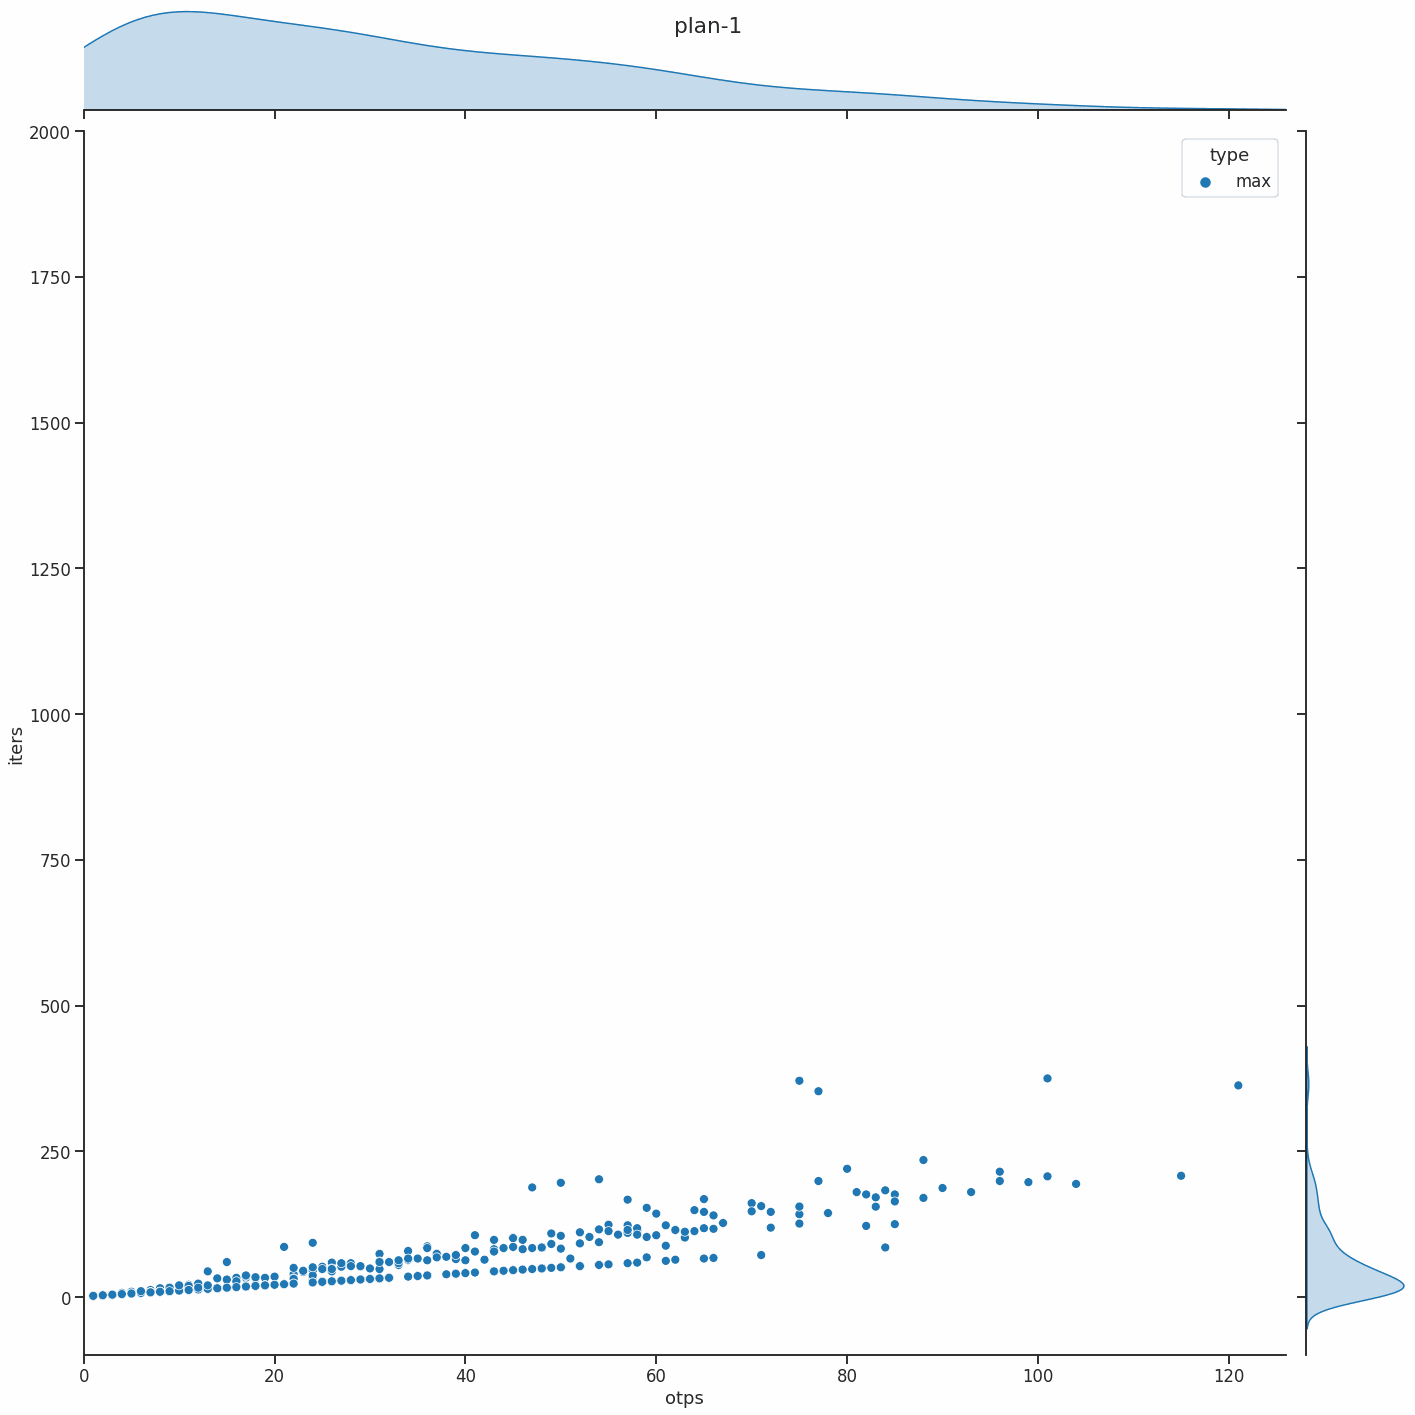

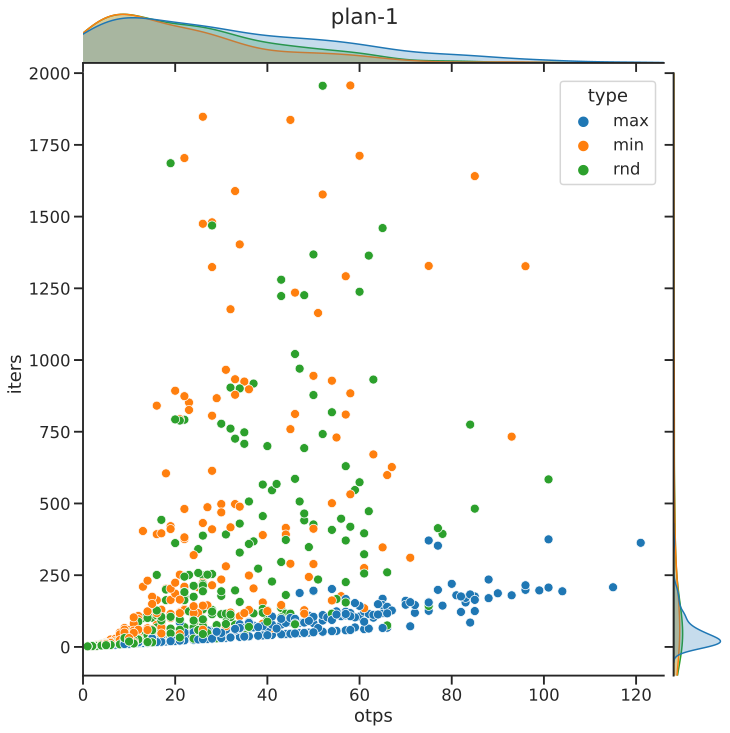

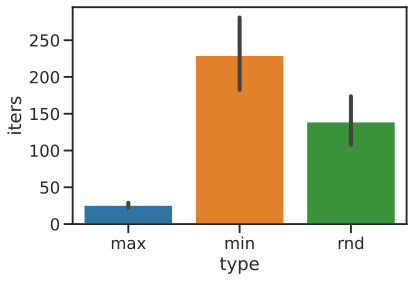

max:   25.808 ±   24.694 | median value is   20.0
min:  229.468 ±  376.427 | median value is   64.0
rnd:  139.252 ±  265.512 | median value is   40.5


In [23]:
show_info("plan-1", xlim = (0, None), ylim = (-100, 2000))

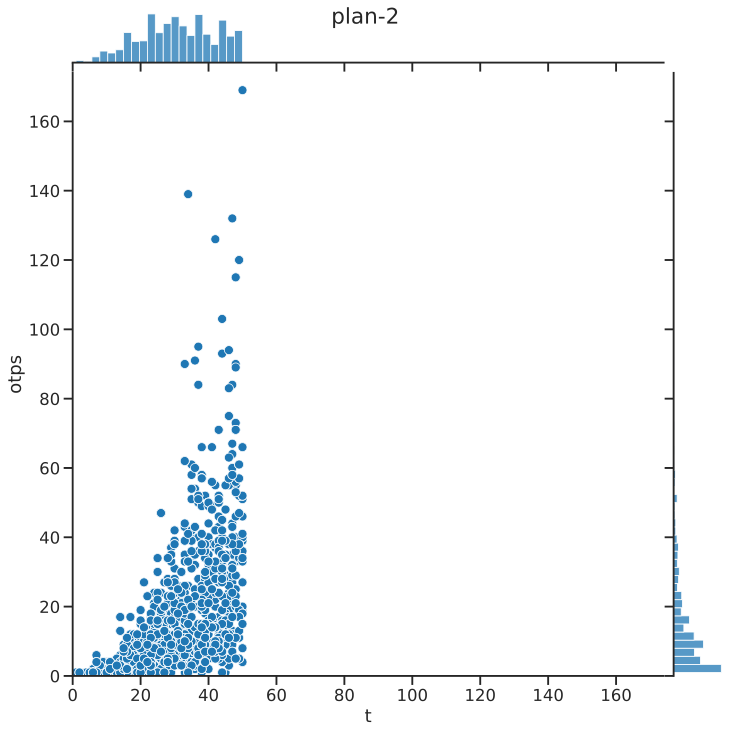

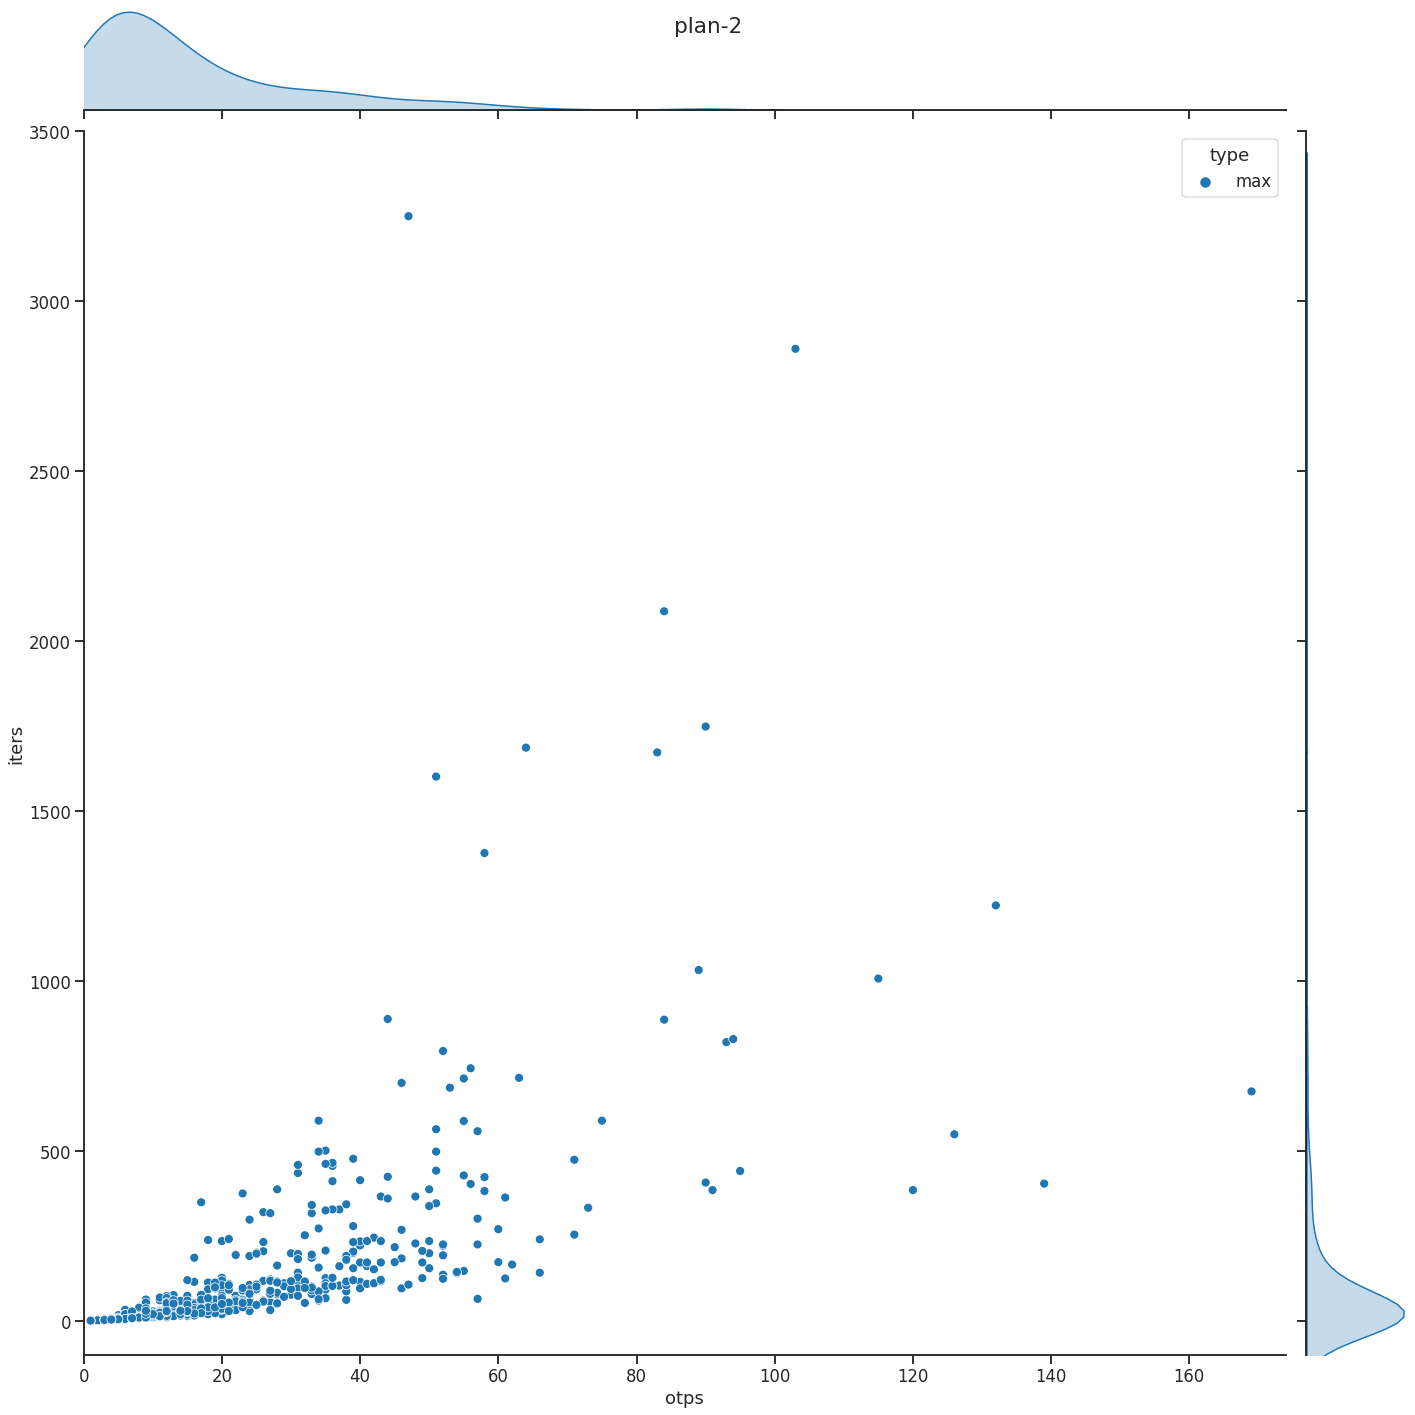

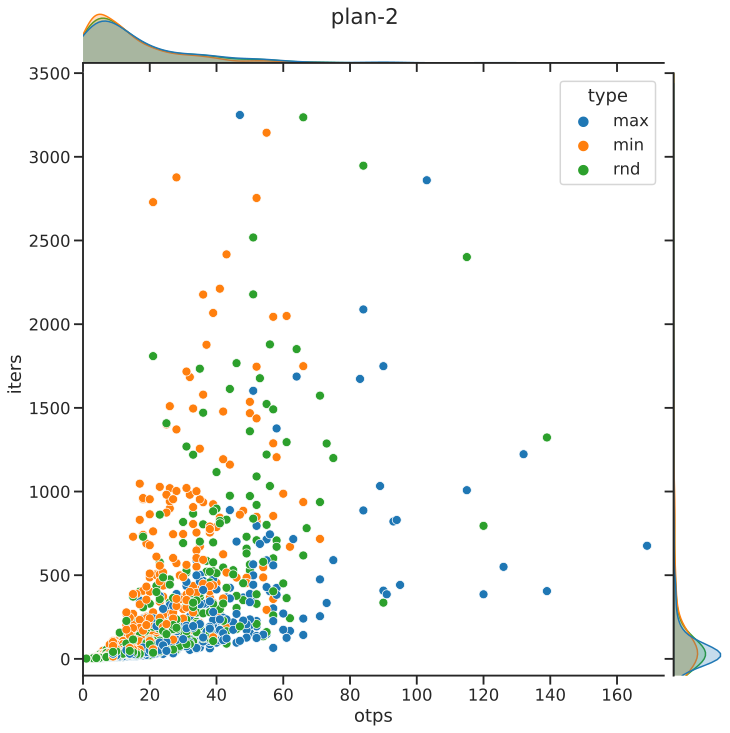

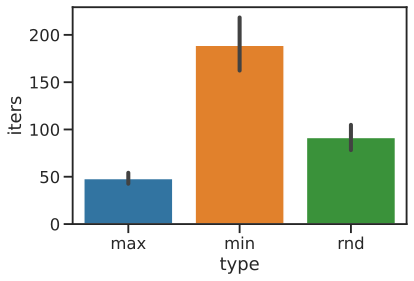

max:   48.144 ±   82.734 | median value is   16.0
min:  189.051 ±  413.352 | median value is   30.0
rnd:   91.592 ±  191.678 | median value is   22.0


In [24]:
show_info("plan-2", xlim = (0, None), ylim = (-100, 3500))